## 提问：加更多层总是改进精度吗
- 模型偏差
- "Nested function classes" VS "Non-nested function classes"
![softmax-description](./imgs/29-1.png)

## 残差块
- 串联一个层是**改变**函数类（左下图），但是我们希望能**扩大**函数类（右下图）
- 可以理解为网路里嵌入了之前的小网络，然后我们先去拟合小网络
![softmax-description](./imgs/29-2.png)

## ResNet块细节
两种块:skipping不一样
![softmax-description](./imgs/29-3.png)

## 不同的残差块
![softmax-description](./imgs/29-6.png)

## ResNet块
- 高宽减半ResNet块（步幅为2）（会令通道数增加一倍）
- 后接多个高宽不变的ResNet块
![softmax-description](./imgs/29-5.png)
- ResNet架构类似VGG和GoolgeNet的总体架构，但是替换成了ResNet块

## 总结
- 残差块是的很深的网络更加容易训练
（理解：不管网络多深，它都会把下面的小网络（不加F(x)的）训练好，慢慢再去训练更深的）
- 残差网络对随后的深层神经网络设计产生深远的影响，不论是卷积累网络还是全连接类网络
- 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）
- 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
- 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。

In [12]:
import torch
from torch import nn
from torch.nn import functional as F
import d2l


class Residual(nn.Module):  #@save
    # use_1x1conv:要不要用1x1卷积层
    # 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        # 这里可以指定stride
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        # 这里stride默认为1
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        # 这里的1x1卷积层
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3: 
            # 对输入直接作用1x1的卷积
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
# 输入和输出形状一致！
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# 增加通道数的同时，需要进行输出的高宽减半
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
# 
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            # not first_block: 不减半
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # 通道数高宽都不变
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [10]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [14]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


training on cpu


KeyboardInterrupt: 

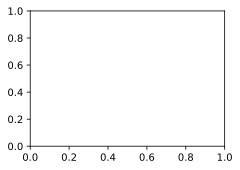

In [15]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())